# Глубокое машинное обучение 

## HW1: Computer Vision

Дата *мягкого* дедлайна: `22.10.2025 23:59`

Дата **жесткого** дедлйна: `29.10.2025 23:59`

### **Правила сдачи (обязательно к прочтению)**
- После **жесткого** дедлайна работы не принимаются.
- После мягкого дедлайна каждый день снимается 10 баллов.
- Все похожие друг на друга работы оцениваются в 0.
- Если вы использовали какой-то публичный код, то это необходимо указать в комментарии и приложить ссылку на источник, иначе тоже может быть 0. :(
- За нечитаемый код, неэффективную реализацию и _некрасивые_ визуализации могут быть сняты баллы.
- Все вычисления должны быть воспроизводимые, поэтому не забывайте про `seed=42`, а также не забудьте перезапустить ноутбук и прожать все ячейки - ошибок быть не должно.
- Готовый ноутбук со всеми данными необходимо положить в архив. В архив необходимо полдожить ваш requirments.txt со всеми версиями библиотек.
- Архив называется следующим образом: `HW1_<your_latin_name>.zip`. Пример: `HW1_malkov.zip`
- Для всех трейнов важно предоставить графики лосов/эпох. Легче всего оставить ссылку на wandb, если такой возможности нет, то делайте графики сами.
- Использовать LLM можно, но допускается не более 50% сгенерированного кода в каждом задании. В случае использования LLM нужно комментарием указать модель, промт и источник инференса. Если нет комментария или количество сгенерированного кода больше 50%, то за задание ставится 0. Пример:
```python
# LLM START
"""
Model: Qwen3-30B-A3B-FP8 (указать квантизацию и кастомные параметры (top-p, top-p, temperature, ...), если есть)
Source: vLLM (здесь может быть API (openrouter.ai), может быть сайт с чатиком (chat.z.ai), может быть тула для локального инференса (lm-studio), может быть TG-бот (@jadvebot))
Prompt: Мой китайский друг, представь, что ты Ян Ле Кун, придумай за меня алгоритм детекции тачулечек
"""
print("Hello world")
# LLM END
```


### **Правила оценки работы**
Всего за работу можно получить 50 баллов. Вся домашняя работа делится на Advanced (для сильных) и Regular _(для нормальных)_, каждый из разделов дает по 25 баллов. Только выполнив Advanced задачи, можно получить **отл**. Чтобы получить **хор** (5), достаточно полностью выполнить все Regular задания.
Вот как выглядит отображение баллов в оценки:
| [От и До) | Оценка |
|-----------|--------|
| 0-5       | 1      |
| 5-10      | 2      |
| 10-15     | 3      |
| 15-20     | 4      |
| 20-26     | 5      |
| 26-30     | 6      |
| 30-35     | 7      |
| 35-40     | 8      |
| 40-45     | 9      |
| 45-50     | 10     |

### Предисловие
Вы уже узнали столько, чтобы попробовать себя в роли настоящего инженера или даже ресерчера. Сегодня мы с нуля пройдем весь путь создания детектора. Наша задача будет заключаться в том, чтобы подготовить модель для детекции медицинских масок на изображении.\

![FaceMask](https://user-images.githubusercontent.com/49322948/159162461-4552eee3-27db-49b2-ab6c-718106adc3c7.jpg)

### 0. Импорт всего, что нужно, и определение всех констант

In [63]:
# My Imports
import os
import json
import xml.etree.ElementTree as ET
from xml.dom import minidom
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

import cv2
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead, SSDLiteRegressionHead

BATCH_SIZE = 8
IMG_SIZE = 300
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

### (reg, 4.0) 1. Разметка

# Использование ИИ

Я использовал GROK через веб интерфейс
Вот промт:
```
Ты специалист в машинном обучении и помогаешь мне выполнить задание в институте по Машинному обучению. Нам с тобой предстоит написать код для обучения модели. Наша задача будет заключаться в том, чтобы подготовить модель для детекции медицинских масок на изображении.

Вот библиотеки и константы, которые нам понадобятся
import cv2
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead, SSDLiteRegressionHead

BATCH_SIZE = 8
IMG_SIZE = 300
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Я буду использовать датасет Medical mask dataset

Я буду давать тебе задания постепенно, а ты должен мне выдавать код, по этому заданию и небольшие пояснения. При этом код должен быть понятным, хорошо написанным и без комментариев внутри
```

дальше просто кидал ему задания и смотрел что он пишет

Здесь нет ссылки на датасет, потому что в реальной жизни данные вам, скорее всего, никто не даст. Вам нужно самим найти все необходимые данные и преобразовать их к нужному виду.

Готовую разметку необходимо подготовить в формате __Pascal VOC__. 

__Ваш датасет нужно запаковать в архив и отправить вместе с работой!__

In [ ]:
# https://humansintheloop.org/resources/datasets/medical-mask-dataset/

In [107]:
# В датасете ещё очки, банданы и проч (это нам не нужно)
# Будем просто искать лица с маской и без
classes = {
    'face_with_mask': 1,
    'face_with_mask_incorrect': 2,
    'face_no_mask': 3,
    'face_other_covering': 4
}

def create_voc_xml(image_path, factors):
    with Image.open(image_path) as img:
        width, height = img.size

    image_name = os.path.basename(image_path)

    annotation = ET.Element('annotation')

    folder = ET.SubElement(annotation, 'folder')
    folder.text = 'Images'

    filename = ET.SubElement(annotation, 'filename')
    filename.text = image_name

    size = ET.SubElement(annotation, 'size')
    width_elem = ET.SubElement(size, 'width')
    width_elem.text = str(width)
    height_elem = ET.SubElement(size, 'height')
    height_elem.text = str(height)
    depth = ET.SubElement(size, 'depth')
    depth.text = '3'

    segmented = ET.SubElement(annotation, 'segmented')
    segmented.text = '0'

    for factor in factors:
        obj = ET.SubElement(annotation, 'object')
        name = ET.SubElement(obj, 'name')
        name.text = factor['name']
        # Хз зачем это, но оно есть в датасетах на кагле и везде Unspecified 0 и 0)
        pose = ET.SubElement(obj, 'pose')
        pose.text = 'Unspecified'
        truncated = ET.SubElement(obj, 'truncated')
        truncated.text = '0'
        difficult = ET.SubElement(obj, 'difficult')
        difficult.text = '0'

        bndbox = ET.SubElement(obj, 'bndbox')
        xmin = ET.SubElement(bndbox, 'xmin')
        xmin.text = str(int(factor['xmin']))
        ymin = ET.SubElement(bndbox, 'ymin')
        ymin.text = str(int(factor['ymin']))
        xmax = ET.SubElement(bndbox, 'xmax')
        xmax.text = str(int(factor['xmax']))
        ymax = ET.SubElement(bndbox, 'ymax')
        ymax.text = str(int(factor['ymax']))

    rough_string = ET.tostring(annotation, 'unicode')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")


def convert_to_voc_format(input_dir, output_dir):
    annotations_dir = os.path.join(input_dir, 'annotations')

    os.makedirs(os.path.join(output_dir, 'annotations'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'meta'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)

    annotation_files = os.listdir(annotations_dir)
    train_images, val_images = [], []
    image_counter = 0
    print(f"Всего: {len(annotation_files)}")

    for ann_file in annotation_files:
        ann_path = os.path.join(annotations_dir, ann_file)

        with open(ann_path, 'r') as f:
            data = json.load(f)

        for annotation in [data]:
            if not isinstance(annotation, dict):
                continue

            image_name = annotation.get('FileName')
            if not image_name:
                continue

            src_path = os.path.join(os.path.join(input_dir, 'images'), image_name)
            number = image_name.split('.')[0]
            dst_path = os.path.join(output_dir, 'images', f'{number}.jpg')

            cv2.imwrite(dst_path, cv2.imread(src_path), [cv2.IMWRITE_JPEG_QUALITY, 95])

            factors = annotation.get('Annotations', [])
            filtered_factors = []

            for factor in factors:
                if isinstance(factor, dict) and factor.get('classname') in classes:
                    bbox = factor.get('BoundingBox', [])
                    filtered_factors.append({
                        'name': factor.get('classname'),
                        'xmin': bbox[0],
                        'ymin': bbox[1],
                        'xmax': bbox[2],
                        'ymax': bbox[3]
                    })

            with open(os.path.join(output_dir, 'annotations', f'{number}.xml'), 'w') as f:
                f.write(create_voc_xml(dst_path, filtered_factors))

            # Берём каждый восьмой
            image_counter += 1
            if image_counter % 8 != 0:
                train_images.append(number)
            else:
                val_images.append(number)

    with open(os.path.join(output_dir, 'meta', 'train.txt'), 'w') as f:
        f.write('\n'.join(train_images))

    with open(os.path.join(output_dir, 'meta', 'val.txt'), 'w') as f:
        f.write('\n'.join(val_images))

    print(f"Train: {len(train_images)}")
    print(f"Val: {len(val_images)}")


In [93]:
shutil.rmtree('voc_dataset', ignore_errors=True)
convert_to_voc_format('dataset', 'voc_dataset')

Всего: 6024
Train: 5271
Val: 753


# Фантастика! Теперь у нас всё в jpg так ещё и весит в два раза меньше

### 2. Подготовка датасета
О, ну вот и задание на код. Всё просто, нужно подготовить `dataset` и `loader`, которые будут использоваться для трейна и теста.

#### (reg, 1.0) 2.1 Определение датасета.


In [108]:
class MyVOCDataset(Dataset):
    def __init__(self, voc_root, split='train', transforms=None):
        self.voc_root = voc_root
        self.images_dir = os.path.join(voc_root, 'images')
        self.annotations_dir = os.path.join(voc_root, 'annotations')
        self.split_file = os.path.join(voc_root, 'meta', f'{split}.txt')
        self.transforms = transforms

        self.image_list = []
        with open(self.split_file, 'r') as f:
            self.image_list = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.images_dir, f'{img_name}.jpg')

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        xml_path = os.path.join(self.annotations_dir, f'{img_name}.xml')
        has_annotations = os.path.exists(xml_path)

        boxes = []
        labels = []

        if has_annotations:
            tree = ET.parse(xml_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                class_name = obj.find('name').text
                if class_name in classes:
                    bbox = obj.find('bndbox')
                    boxes.append([
                        float(bbox.find('xmin').text),
                        float(bbox.find('ymin').text),
                        float(bbox.find('xmax').text),
                        float(bbox.find('ymax').text)
                    ])
                    labels.append(classes[class_name])

        boxes = np.array(boxes, dtype=np.float32) if boxes else np.empty((0, 4), dtype=np.float32)
        labels = np.array(labels, dtype=np.int64) if labels else np.empty((0,), dtype=np.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)

        return image, target

#### (reg, 1.0) 2.2 Подготовка аугументации
Аугументацию необходимо делать с помощью `albumentations`.

In [109]:

# Код с семинаров
train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.PadIfNeeded(border_mode=cv2.BORDER_CONSTANT, fill=0),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7, border_mode=cv2.BORDER_CONSTANT, fill=0),
    A.MotionBlur(p=0.2),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', # и даже без всяких from torchvision.ops import box_convert
                            label_fields=['labels'],
                            min_visibility=0.2, # и даже регулируем видимость
                            clip=True)) # и даже удаляем боксы, если они выходят за рамки изображений))


# Да-да, для теста аугументация не нужна, только базовые преобразования
test_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', # и даже без всяких from torchvision.ops import box_convert
                            label_fields=['labels'],
                            min_visibility=0.2, # и даже регулируем видимость
                            clip=True))


#### 2.3 Cобираем всё вместе

In [110]:
train_dataset = MyVOCDataset('voc_dataset', split='train', transforms=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

test_dataset = MyVOCDataset('voc_dataset', split='val', transforms=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

#### (reg, 0.5) 2.4 Визулизация датасета
Визуализируйте пару примеров, чтобы убедиться, что вы нигде не ошиблись в разметке.

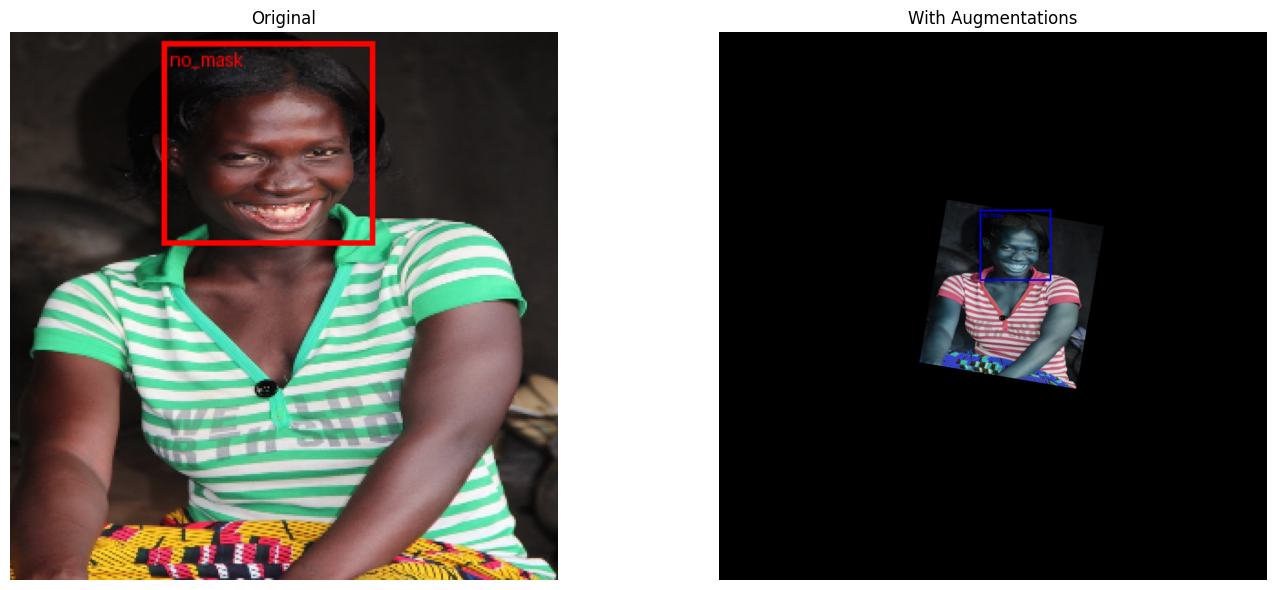

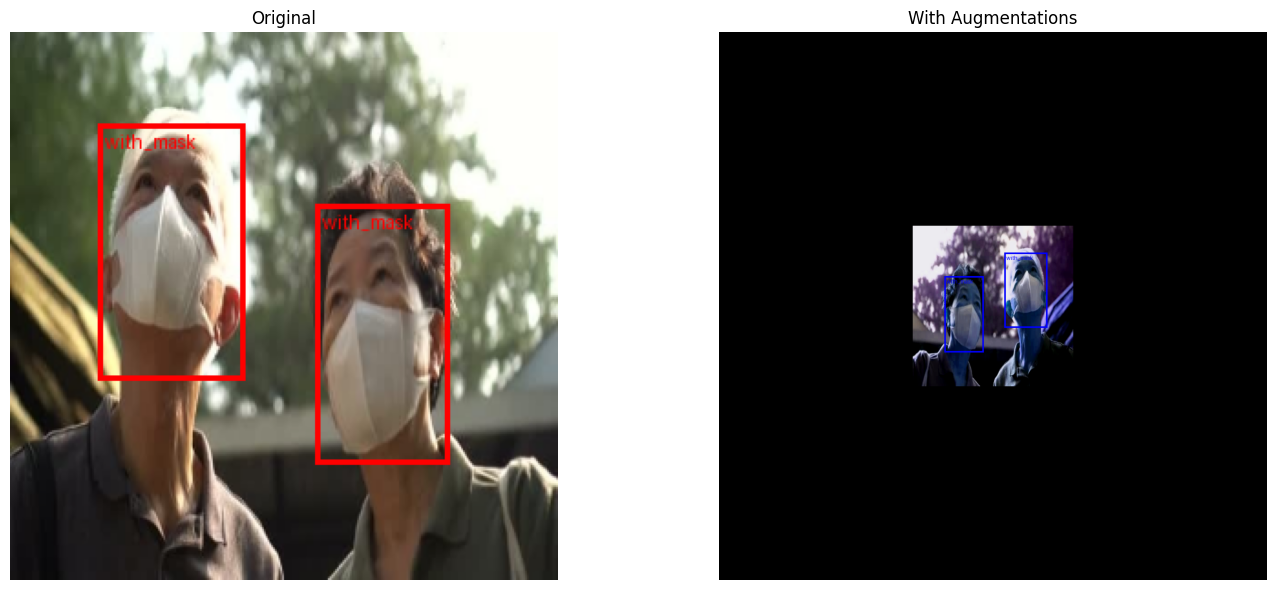

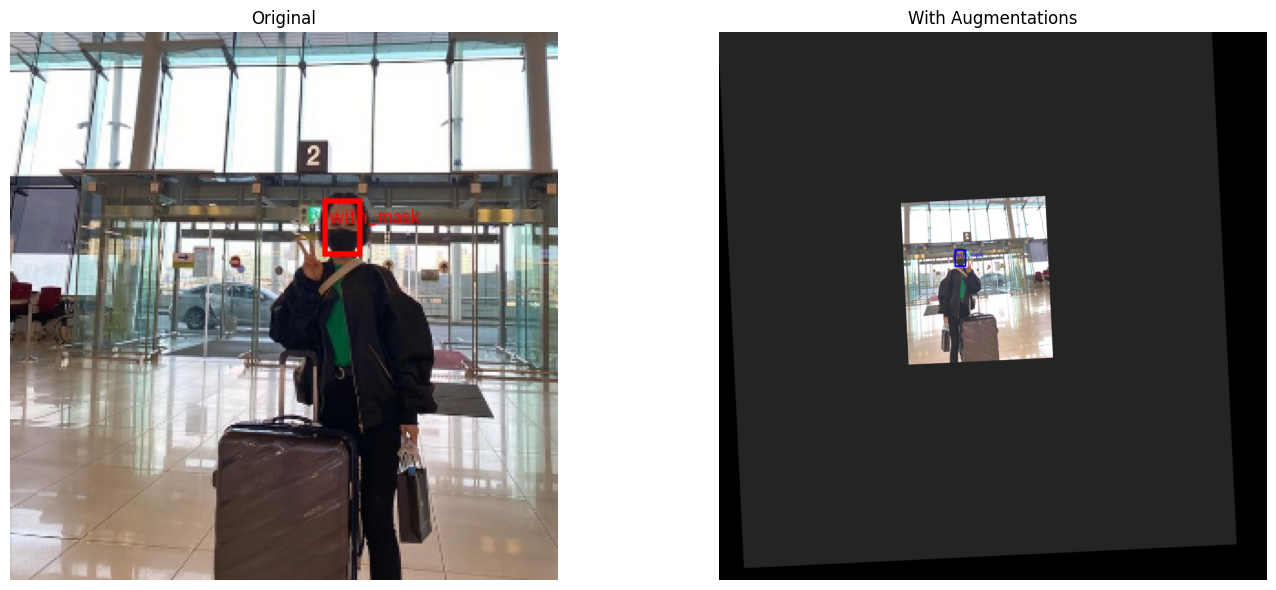

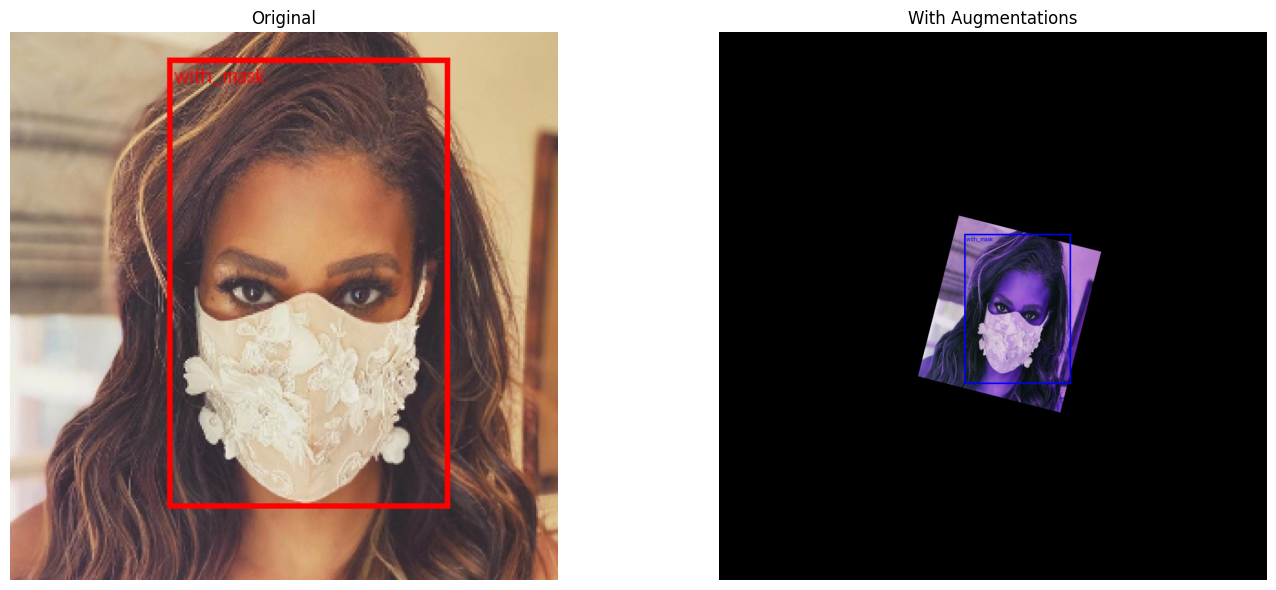

In [119]:
def visualize_augmentations(original_dataset, augmentated_dataset, index=0):
    orig_image, orig_target = original_dataset[index]
    aug_image, aug_target = augmentated_dataset[index]

    # LLM START: Исправь этот код так, чтобы в у боксов писались классы из данных(из датасета)
    class_names = {v: k for k, v in classes.items()}
    orig_boxes = orig_target['boxes']
    orig_labels = [class_names.get(label.item(), 'unknown')[5:] for label in orig_target['labels']]

    aug_boxes = aug_target['boxes']
    aug_labels = [class_names.get(label.item(), 'unknown')[5:] for label in aug_target['labels']]
     # LLM END

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    orig = draw_bounding_boxes(orig_image, orig_boxes, labels=orig_labels, width=3, colors='red')
    axes[0].imshow(orig.permute(1, 2, 0).numpy())
    axes[0].set_title('Original')
    axes[0].axis('off')

    aug = draw_bounding_boxes(aug_image, aug_boxes, labels=aug_labels, width=3, colors='blue')
    axes[1].imshow(aug.permute(1, 2, 0).numpy())
    axes[1].set_title('With Augmentations')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

test_dataset_no_aug = MyVOCDataset('voc_dataset', split='train', transforms=test_transforms)
visualize_augmentations(test_dataset_no_aug, train_dataset, index=random.randint(0, 1000))
visualize_augmentations(test_dataset_no_aug, train_dataset, index=random.randint(0, 1000))
visualize_augmentations(test_dataset_no_aug, train_dataset, index=random.randint(0, 1000))
visualize_augmentations(test_dataset_no_aug, train_dataset, index=random.randint(0, 1000))

### 3. Обучение претрейн модели
Очень вам завидую, ведь это ваш первый настоящий трейн!

В прошлом курсе вы уже обучали бустинги и, может даже, с какими-нибудь сложными `hyperopt` или `gridsearch`, но поверьте — это совсем не то. В этом задании вам пригодится абсолютно всё, что мы к этому времени прошли, + мощности colab/kaggle/... + много времени и терпения. А всё почему? А всё потому, что мы будем с вами реализовывать **SSD** с нуля без каких-либо претрейнов и без VGG в бэкбоне (это всё-таки пережиток прошлого). Ну и сравним, что у нас получится с реализацией из `torchvision`, если всё сойдется.

#### 3.0 Теоретическая вводная.

Мы уже обсуждали на лекции, что такое SSD, и если кратко, то это One-Stage детектор, аналогичный YOLO, в котором есть несколько трюков:
1. Берут готовый бэкбон (VGG16), а не обучают его с нуля на ImageNet.
2. Вместо FC слоев используют только свертки. (прям как в RPN Faster-RCNN)
3. Из оригинальной VGG убирают все полносвязные слои и добавляют дополнительно 5 слоев сверток.
4. Вместо одного последнего слоя/активации (как в YOLO) берут 6 слоев из разных мест сети и «делают на них предсказания». Нужно это для того, чтобы лучше работать с объектами маленьких размеров, с которыми YOLO работает плохо.

Если более простыми словами объяснять проблематику из пункта 4, то в случае YOLO мы после всех преобразований оригинального изображения 448х448(x3) мы получаем карту активации 7x7(x1024). Таким образом, для каждого 64x64 квадрата оригинального изображения мы имеем всего 1x1x1024 фичи, характеризующий каждый из квадратов 64x64, при этом пространственной информации о содержании этих квадратов там почти нет. Зато пространственной информации будет больше на более ранних картах активации, например, размера 32х32, где каждый «элемент сетки» уже будет отвечать за квадрат 14x14 оригинального изображения. При этом, очевидно, «фичи» из карты активации 32х32 будут «слабее» фичей из 7х7, просто потому что слой 7х7 глубже. 

![SSD](https://www.acetrace.app/images/illustrations/ssd.png)

Если всё ещё не очень понятно, что в этом вашем SSD происходит, то обязательно посмотрите вот на этот реп: [клик](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection).

#### 3.1 Практическая вводная
Первое, что вам нужно сделать, — это прочитать [статью](https://arxiv.org/pdf/1512.02325) с вниманием ко всем деталям. Оттуда, например, нужно заимствовать формулки для расчета скейла: $s_k = s_{min} + \frac{s_{max}-s_{min}}{m-1}(k-1)$ и узнать про _hard negative mining_ (все нюансы из статьи правда важны, её же не глупые люди писали!).

Какие-то детали с точки зрения имплементации можно подчерпнуть из:
- [официальной имплементации](https://github.com/weiliu89/caffe/blob/2c4e4c2899ad7c3a997afef2c1fbac76adca1bad/examples/ssd/ssd_coco.py).
- [популярной учебной имплементации](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py).
- [имплементации команды torch](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/ssd.py).
- [просто чья-то имплементация](https://github.com/amdegroot/ssd.pytorch/tree/master).

Также очень рекомендую прочитать блог команды torch относительно имплементации SSD и SSD-Lite (это SSD с MobileNet в бэкбоне):
- [SSD](https://pytorch.org/blog/torchvision-ssd-implementation/).
- [SSD-Lite](https://pytorch-hub-preview.netlify.app/blog/torchvision-ssdlite-implementation/).

#### **3.2 План действий (обязательно к прочтению)**
Теперь по поводу плана. Если вы не GPU-rich и не имеете доступа к серверу хотя бы с 4 GPU, то у вас вряд ли получится сделать претрейн SSD с нуля, чтобы она прям была пригодна для использования, поэтому мы с вами сфокусируемся на самой архитектуре и на непосредственно процессе обучения. Пункт с обучением своей модели будет выполнен, если:
1. Всё в вашей имплементации будет по делу.
2. Ваша имплементация будет спокойно **переобучаться** на одном батче за 1000 итераций. Это значит, что вы все правильно имплементировали.
3. У вас будет хотя бы **10-20 эпох**, где видно, что лосс классификации и лосс регрессии уверенно сходятся. При этом вам нужно показать минимум **пять** конфигураций обучения (с разными гиперпараметрами/лосами/оптимизациями/архитектурными триками). 

Если вы все сделали всё правильно, то на ваших графиках loss-а вы увидите что-то такое:
<div>
<img src="https://d3e0luujhwn38u.cloudfront.net/resized/kz9vKVmfahkZKS5UC_tJ8SJVHjeHIGDO8X-wiz8PzU8/s:3200/plain/s3://typefully-user-uploads/img/original/36777/1e59208e-44c4-4ed1-9c13-ee0010afc4cb.png" width="500"/>
</div>

Теперь пару советов с точки зрения самой реализации:
1. Бэкбон предлагаю брать максимально компактный типа MobileNetV3.
2. Предлагаю не брать какой-то большой датасет типа [COCO](https://public.roboflow.com/object-detection/microsoft-coco-subset/2), а ограничится [PASCAL VOC](https://public.roboflow.com/object-detection/pascal-voc-2012/1).
3. Здорово, если вы в какой-то имплементации увидите, что авторы используют SGD, а в другой использует какие трики с масштабированием дисперсии, но будьте уверены, в вашем случае это может не работать или работать не очень хорошо. Нужно все проверять самостоятельно.  

Куда обязательно нужно посмотреть: 
1. Уменьшения изображения — это ок для нашего домашнего претрейна.
2. Инициализация весов — это очень важно.
3. Сильный дисбаланс классов надо в любом случае компенсировать.

И несколько практических советов:
1. Обязательно делайте чекпоинты во время трейна.
2. Старайтесь сделать код максимально гибким и удобным для ваших экспериментов, а не копипастить одну и ту же функцию трейна с разными оптимизаторами.
3. Внимательно смотрите не только на значения лосов по эпохам, но по всем итерациям/степам — это сэкономит вам время.
4. Обязательно логируйте все эксперименты в тексте/тензорборде/wandb и смотрите графики. Не забывайте делать оценку на val-выборке, особенно если используете не очень большой датасет типа PASCAL.

#### (adv, 5.0) 3.3 Определение модели
VGG, скорее всего, очень сильно отличается по архитектуре от выбранного вами бэкбона, поэтому вам самостоятельно нужно подобрать слои, из которых брать фичи, а также определить количество анкеров и базовые соотношения сторон боксов.

Для того чтобы долго не высчитывать, какой размер сверток вам нужен на каждом этапе, лучше просто посмотреть, какие шейпы получаются на каждом слое. Вот пример кода:
```python
backbone = torchvision.models.get_model("mobilenet_v3_large", weights="DEFAULT").features
x = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
for i, layer in enumerate(backbone):
    x = layer(x)
    print('back', i, x.shape)

extra_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(960, 256, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU6(inplace=True),
                SeparableConv2d(256, 512, kernel_size=3, stride=2, padding=1)
            ),
            nn.Sequential(
                nn.Conv2d(512, 128, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU6(inplace=True),
                SeparableConv2d(128, 256, kernel_size=3, stride=2, padding=1)
            ),
        ])

for i, layer in enumerate(extra_layers):
    x = layer(x)
    print('ext', i, x.shape)
```

In [105]:
class MySSD(nn.Module):
    def __init__(self, *args):
        super().__init__()
        # YOUR CODE HERE 

    def _generate_default_boxes(self, *args, s_min=0.1, s_max=0.9):
        """
        Функция генерации дефолтных боксов, как из статьи
        """
        # YOUR CODE HERE
        return

    def forward(self, x):
        # YOUR CODE HERE
        return

#### (adv, 2.0) 3.4 Определение лоса
В оригинальной статье лосс состоит из двух компонет: лосс регрессии (L1_smooth) и лосс классификации (кросс-энтропия) с трюком Hard negative mining.

In [106]:
class MySSDLoss(nn.Module):
    def __init__(self, *args):
        super().__init__()
        # YOUR CODE HERE

    def forward(self, *args):
        # YOUR CODE HERE
        return conf_loss + self.alpha * loc_loss, conf_loss, loc_loss

#### (adv, 1.0) 3.5 Аугументация для претрейна

In [107]:
# YOUR CODE HERE
pre_train_transforms = A.Compose([])
pre_val_transforms = A.Compose([])

#### (adv, 1.0) 3.6 Подготовка датасета и лоудера для претрейна
> Нужно обязательно переисользовать `MyVOCDataset`.

In [108]:
# YOUR CODE HERE

# pre_train_dataset =
# pre_train_loader = 

# pre_val_dataset =
# pre_val_loader =

# pre_test_dataset =
# pre_test_loader =

#### (reg, 2.0) 3.7 Визулизация датасета
Визуализируйте пару примеров, чтобы убедиться, что вы нигде не ошиблись в разметке.

In [109]:
# YOUR CODE HERE

#### (adv, 1.0) 3.8 Подготовка train-loop для переобученя на одном батче
> Не забывайте про перевод модели в режим трнйна (`model.train()`) или в режим инференса (`model.eval()`), а также помните про контекстный менджер: (`torch.no_grad()`).

In [110]:
def run_single_batch_overfit(*args, iterations=1500):
    # YOUR CODE HERE
    pass

#### (adv, 2.0) 3.9 Оверфит на одном батче

In [111]:
# YOUR CODE HERE

#### (adv, 1.0) 3.10 Визуализация экспериментов

In [112]:
# YOUR CODE HERE OR LINK TO WANDB OR ANY VISUALIZAION

#### (adv, 1.0) 3.11 Подготовка train-loop для обучения претрейна


In [113]:
def run_training_stage(*args, ):
    # YOUR CODE HERE
    pass

#### (adv, 8.0) 3.12 Обучение претрейна
> Не нужно ждать, что все сойдется, достаточно просто показать 5 разных конфигураций обучения с 20-30 эпохами, где лосс _уверенно_ падает.

In [114]:
# YOUR CODE HERE

#### (adv, 1.0) 3.13 Визуализация экспериментов

In [115]:
# YOUR CODE HERE OR LINK TO WANDB OR ANY VISUALIZAION

Если вы дошли до этого пункта, то вы просто герой! („• ֊ •„)੭

По секрету: если на собеседовании вы скажете, что вы _Senior AI Developer_, то никто даже не поймет подвоха.

### 4. Обучение основной модели на базе готового претрейна
В этом блоке мы зафайнтюним предобученную SSD-Lite на нашей собственной разметке.

#### (reg, 1.0) 4.1 Импортируйте веса модели
Вот сразу ссылка на сурсы, если что: [клик](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/ssdlite.py). Для вас задача ещё сложнее: дефолтно в [SSD](https://github.com/pytorch/vision/blob/7a13ad0f89167089616b51f4fd07f978cf1f17e4/torchvision/models/detection/ssd.py#L453) и [SSD-Lite](https://github.com/pytorch/vision/blob/7a13ad0f89167089616b51f4fd07f978cf1f17e4/torchvision/models/detection/ssdlite.py#L310) включен NMS, а нам надо его выключить, потому что мы сделаем его сами. Напомнию, что NMS на этапе обучения __[не нужен](https://github.com/pytorch/vision/blob/7a13ad0f89167089616b51f4fd07f978cf1f17e4/torchvision/models/detection/ssd.py#L404)__.

In [129]:
model = ssdlite320_mobilenet_v3_large(weights="DEFAULT")

# YOUR CODE HERE

# model.to(DEVICE)

#### (reg, 4.0) 4.1 Подготовьте train-loop

In [117]:
def train_ssd(*args, ):
    # YOUR CODE HERE
    pass

#### (reg, 3.0) 4.2 Обучите модель на нашем датасете

In [118]:
# YOUR CODE HERE

#### (reg, 2.0) 4.3 Визуализация эксперимента

In [119]:
# YOUR CODE HERE OR LINK TO WANDB OR ANY VISUALIZAION

#### (reg, 2.0) 4.4 Реализация NMS
Мы уже обсуждали алгоритм NMS на лекции, но если забылось, то вот отличная [статья](https://deepmachinelearning.ru/docs/Neural-networks/Object-detection/Non-maximum-supression).

In [120]:
def nms(boxes, scores_max, iou_threshold):
    # YOUR CODE HERE
    pass

#### (reg, 2.0) 4.5 Реализация функции декодирования предсказаний
Нужно реализовать функцию для переовода offset + default_box/anchors, которые выдает модель, в xyxy bbox.

In [121]:
def decode_boxes(box_preds, default_boxes):
    # YOUR CODE HERE
    pass

#### (reg, 0.5) 4.5 Визализация работы модели на val датасете
Выведит пару примеров детекции масок

In [122]:
# YOUR CODE HERE

#### (reg, 2.0) 4.6 Подсчет IoU
Для того чтобы оценить качество работы самой детекции чаще всего измеряют IoU. Пропустите вашу модель чере NMS и посчитайте IoU отонсительно Ground Truth. Вычисление IoU нужно реализовать самостоятелньо!

In [123]:
def calculate_iou(boxs1, boxs2):
    # YOUR CODE HERE
    pass

# YOUR CODE HERE

#### (reg, 2.0) 4.7 Подсчет mAP
Про `Mean Average Precision` вы точно слышали из прошлого курса. Считается немного модифицированный `PR AUC` по всем наблюдениям одного класса (у нас он только один, фон не считается) и получаем `AP`, а дальше усредняем `AP` по всем классам и получаем `mAP`. [Тут](https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/) пример на пальцах. Расчет mAP тоже нужно реализовать самостоятельно.

In [124]:
def map(*args, iou_threshold=0.5, score_threshold=0.01):
    # YOUR CODE HERE
    pass

# YOUR CODE HERE

### 5. Обучение модели на базе собственного претрейна
**Все пункты дальше необязательные! И их можно делать, только если у вас хоть чуть-чуть сошелся лосс и модель классифицирует объекты лучше рандома!**

#### 5.1 Дообучение вашего претрейна 

In [125]:
# YOUR CODE HERE

#### 5.2 Визуализация эксперимента

In [126]:
# YOUR CODE HERE

#### 5.3 Подсчет IoU

In [127]:
# YOUR CODE HERE

#### 5.3 Подсчет mAP

In [128]:
# YOUR CODE HERE